# Solving configuration selection and prioritization using QAOA

We want to find an (almost) optimal configuration in an attributed feature model.
This problem can be described as two subproblems: a constraint satisfaction problem and a cost optimization problem.

The validity part of the problem can be described by the following boolean formulae:
$
(x_1 \vee x_2) \wedge (x_3 \oplus x_4) \wedge (x_5 \implies x_6)
\iff
(x_1 \vee x_2) \wedge (\neg x_3 \vee \neg x_4) \wedge (x_3 \vee x_4) \wedge (\neg x_5 \vee x_6)
$

The right hand side is in conjunctive normal form (CNF).

The cost optimization part of the problem is described by assinging a cost to each feature, as shown in the table below.

| Feature | Cost $c_i$ |
| --- | --- |
| $x_1$ | 30 |
| $x_2$ | 20 |
| $x_3$ | 25 |
| $x_4$ | 50 |
| $x_5$ | 10 |
| $x_6$ | 10 |

# Quantum Approximate Optimization Algorithm

The Quantum Approximate Optimization Algorithm (QAOA) is a variational quantum algorithm that is used for solving combinatorial optimization problems.
It approximates the solution of a combinatorial optimization problem consisting of:
- $n$ binary variables
- $m$ clauses
- objective function $C(\vec z)$

The quantum circuit for QAOA consists of two operators: the phase-separating operator $U_C$ and the mixing operator $U_M$.
The two operators $U_C$ and $U_M$ are applied alternately and parametrized by the parameters $\gamma$ and $\beta$ respectively.
The parameters are optimized to minimize the cost function $C(\vec z)$ using a classical optimization algorithm.

The phase-separating operator $U_C$ encodes $C$ and applies a phase shift $e^{-i \vec \gamma}$ on every computational basis state for every clause that is fulfilled.
The (standard) mixing operator $U_M$ changes the amplitude of solutions using rotation gates $R_x$.

Both $U_C$  and $U_M$ are then applied $p$ times according to the hyper-parameter $p \in \mathbf{N}$.
Finally measurements gates are added.


## Quantum Circuit

We start by defining the parameterized circuit.

In [1]:
# Notebook Setup
from IPython.core import page
page.page = print

# Imports used for examples
from qiskit.visualization import plot_histogram
from pprint import pprint

### Initialization

The initialization of the quantum circuit can either be done by creating a uniform superposition using Hadamard gates $H$ on each qubit or by using a state that has previously been found using for example another algorithm like Grover's algorithm.
The latter can be achieved using the `initialize` method in Qiskit.

In [2]:
# Uniform Superposition Initialization
from fragments.quantum_states import superposition_circuit, add_all_hadamards
%psource superposition_circuit
%psource add_all_hadamards

def superposition_circuit(nqubits: int) -> QuantumCircuit:
    """
        Create a new quantum circuit where all qubits are initialized to |+>
    """
    qc_0 = QuantumCircuit(nqubits)
    return add_all_hadamards(qc_0, range(nqubits))

def add_all_hadamards(qc, nqubits):
    """
        Apply an H-gate to all 'qubits' in qc
    """
    for q in nqubits:
        qc.h(q)
    return qc


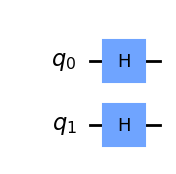

In [3]:
superposition_circuit(2).draw(output="mpl")

### Mixing Operator

#### Standard Mixer

The standard mixing operator $U_M$ applies a rotation around $X$ of $2*\beta$ on every qubit using $R_x$ gates.

In [4]:
# Mixer Hamiltonian
import qaoa.qaoa_mixer as mixer
%psource mixer.standard_mixer

def standard_mixer(nqubits: int, beta: Parameter, statevector: list[float] = None) -> QuantumCircuit:
    """
        Creates a standard mixer circuit for the given number of qubits and beta

        :param nqubits: The number of qubits to create the circuit for
        :param beta: The parameter to use for the circuit
        :param statevector: The statevector to use for the circuit (not used for this mixer)
    """
    qc_mix = QuantumCircuit(nqubits)
    for i in range(0, nqubits):
        qc_mix.rx(2 * beta, i)
    return qc_mix


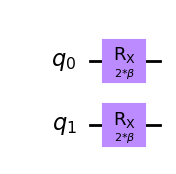

In [5]:
from qiskit.circuit import Parameter

example_qc_mixer = mixer.standard_mixer(2, Parameter("$\\beta$"))
example_qc_mixer.draw(output="mpl")

#### Grover Mixer

The Grover mixer is another mixing operator that has a similar structure to the circuit used in Grover's algorithm.
It consists of the inverse of the state preparation circuit, followed by $X$ gates on each qubit.
In the middle is a multi-controlled $R_z$ gate and then again $X$ gates on each qubit followed by the (not inversed) state preparation circuit.

In [6]:
%psource mixer.grover_mixer

def grover_mixer(nqubits: int, beta: Parameter, statevector: list[float] = None) -> QuantumCircuit:
    """
        Creates a grover mixer circuit for the given number of qubits and beta

        :param nqubits: The number of qubits to create the circuit for
        :param beta: The parameter to use for the circuit
        :param statevector: The statevector to use for the circuit
    """
    qc_mix = QuantumCircuit(nqubits)

    if statevector is None:
        qc_state_preparation = QuantumCircuit(nqubits)
        for i in range(nqubits):
            qc_state_preparation.h(i)
    else:
        qc_state_preparation = get_state_preparation_circuit(nqubits, statevector)

    qc_mix = qc_mix.compose(qc_state_preparation.decompose(reps=2).inverse())

    for i in range(0, nqubits):
        qc_mix.x(i)

    qc_mix = qc_mix.compose(MCMT(RZGate(2 * beta), nqubits - 1, 1, label=None))

    for i in range(0, nqubits):
        qc_mix.x(i)

    qc_mix = qc_mix.compose(qc_state_preparation)

    r

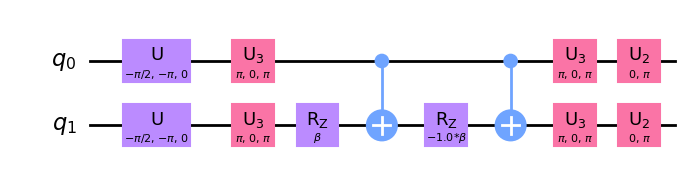

In [7]:
# To work with the Statevector Simulator we need to call `decompose` on the circuit. Thus, the output here is not exactly the same as described above.

example_qc_grover_mixer = mixer.grover_mixer(2, Parameter("$\\beta$"))
example_qc_grover_mixer.draw(output="mpl")

#### Warmstart Mixer

A simple mixer used when warmstarting the QAOA algorithm can be achieved by applying the inverse of the state preparation circuit, followed by $R_z$ gates on each qubit and then again the (not inversed) state preparation circuit.

In [8]:
%psource mixer.warmstart_mixer

def warmstart_mixer(nqubits: int, beta: Parameter, statevector: list[float] = None) -> QuantumCircuit:
    """
        Creates a warmstart mixer circuit for the given number of qubits, beta and statevector according to the paper by
        Egger et al. (https://quantum-journal.org/papers/q-2021-06-17-479/)

        :param nqubits: The number of qubits to create the circuit for
        :param beta: The parameter to use for the circuit
        :param statevector: The statevector to use for the circuit
    """
    if statevector is None:
        raise ValueError("Statevector cannot be None for warmstart mixer")
    qc_mix = QuantumCircuit(nqubits)

    qc_state_preparation = get_state_preparation_circuit(nqubits, statevector)

    qc_mix = qc_mix.compose(qc_state_preparation.inverse())

    for i in range(0, nqubits):
        qc_mix.rz(-2 * beta, i)

    qc_mix = qc_mix.compose(qc_state_preparation)

    return qc_mix


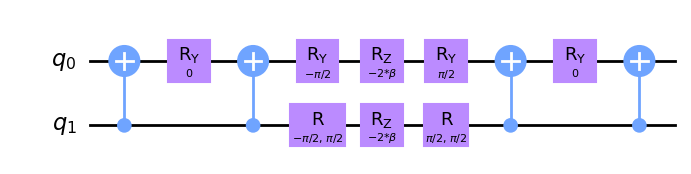

In [9]:
dummy_statevector = [0.5, 0.5, 0.5, 0.5]

example_qc_warmstart_mixer = mixer.warmstart_mixer(2, Parameter("$\\beta$"), statevector=dummy_statevector)
example_qc_warmstart_mixer.draw(output="mpl")

### Phase-separating Operator

The phase-separating operator $U_C$ encodes $C$ and can be derived from a cost Hamiltonian $H_C$ in Ising-form.

For feature models where the associated SAT problem in CNF contains only clauses with at most two literals, the cost Hamiltonian can be constructed using $R_z$ and $R_{zz}$ gates.
For clauses with more than two literals, the cost Hamiltonian can be constructed using multi-controlled $R_z$ gates which can be decomposed into multiple $CNOT$ gates and one $R_z$ gate.

We later describe how such a Hamiltonian can be constructed for our concrete problem class.

In [10]:
# Hamiltonians may be described as a dict of tuples describing acting qubits and a value for each clause
# hamiltonian = {(q1?, q2?, ...) : factor}
sat_hamiltonian = {
    () : 1,
    (0,): 0.25,
    (1,): 0.25,
    (4,): -0.25,
    (5,): 0.25,
    (0, 1): 0.25,
    (2, 3): 0.5,
    (4, 5): -0.25
}

Clauses on one qubit are then translated into $R_z$ rotations and clauses on two qubits are translated into the symmetric $R_{zz}$ gate.

In [11]:
# Cost Hamiltonian
from qaoa.qaoa_mincost_sat import problem_circuit as qubo_problem_circuit
from qaoa.qaoa_mincost_k_sat import problem_circuit as pubo_problem_circuit
%psource qubo_problem_circuit
%psource pubo_problem_circuit

def problem_circuit(hamiltonian: DictArithmetic, nqubits: int, gamma)\
        -> QuantumCircuit:
    """
        Creates a quantum circuit for the given hamiltonian

        :param hamiltonian: The hamiltonian to create the circuit for
        :param nqubits: The number of qubits to create the circuit for
        :param gamma: The parameter to use for the circuit
    """
    qc_p = QuantumCircuit(nqubits)
    normalization = math.pi/max(hamiltonian.values())
    
    for key, factor in hamiltonian.items():
        acting_qubits = len(key)
        
        if acting_qubits == 0:
            pass  # identity case
        elif acting_qubits == 1:
            # single qubit term
            q1 = key[0]
            qc_p.rz(2 * normalization * factor * gamma, q1)
        elif acting_qubits == 2:
            # quadratic qubit term
            q1 = key[0]
            q2 = key[1]
            qc_p.rzz(2 * normalization * factor * gamma, q1, q2)
        else:
            # non quadratic, error
 

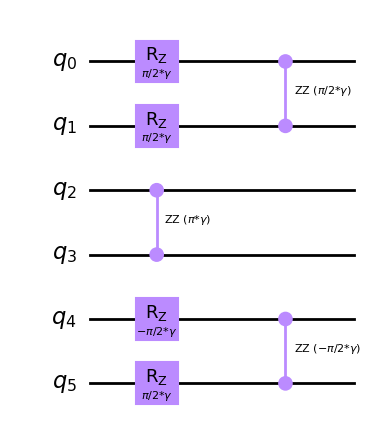

In [12]:
example_qc_problem = qubo_problem_circuit(sat_hamiltonian, 6, Parameter("$\\gamma$"))
example_qc_problem.draw(output="mpl")

Clauses on more than two qubits are translated into multi-controlled $R_z$ gates which are decomposed into $CNOT$ gates and one $R_z$ gate.

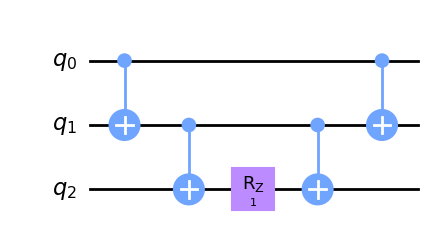

In [13]:
# Example for a multi-controlled R_z gate
from qaoa.qaoa_mincost_k_sat import k_rz_gate
from qiskit import QuantumCircuit

qubits = [0, 1, 2]
multi_controlled_rz = k_rz_gate(QuantumCircuit(len(qubits)), qubits, 1)
multi_controlled_rz.draw(output='mpl')

### QAOA circuit

Now we can create a QAOA circuit for a problem hamiltonian.

In [14]:
# QAOA Circuit
from qaoa.qaoa_application import qaoa_circuit
%psource qaoa_circuit

def qaoa_circuit(problem_circuit: Callable, mixer_circuit: Callable, hamiltonian: DictArithmetic, nqubits: int,
                 nlayers: int, amplitude_vector: list[float] = None, params_per_layer: bool = True,
                 measure: bool = True) -> tuple[QuantumCircuit, list[Parameter], list[Parameter]]:
    """
        Creates a QAOA circuit for the given hamiltonian

        :param problem_circuit: The method for creating the corresponding problem quantum circuit
        :param mixer_circuit: The method for creating the corresponding mixer quantum circuit
        :param hamiltonian: The hamiltonian to create the circuit for
        :param nqubits: The number of qubits to create the circuit for
        :param nlayers: The number of layers to create the circuit for
        :param amplitude_vector: The amplitude vector to use for the circuit
        :param params_per_layer: indicates whether a unique parameter pair should be used for each layer
        :param measure: Whether to me

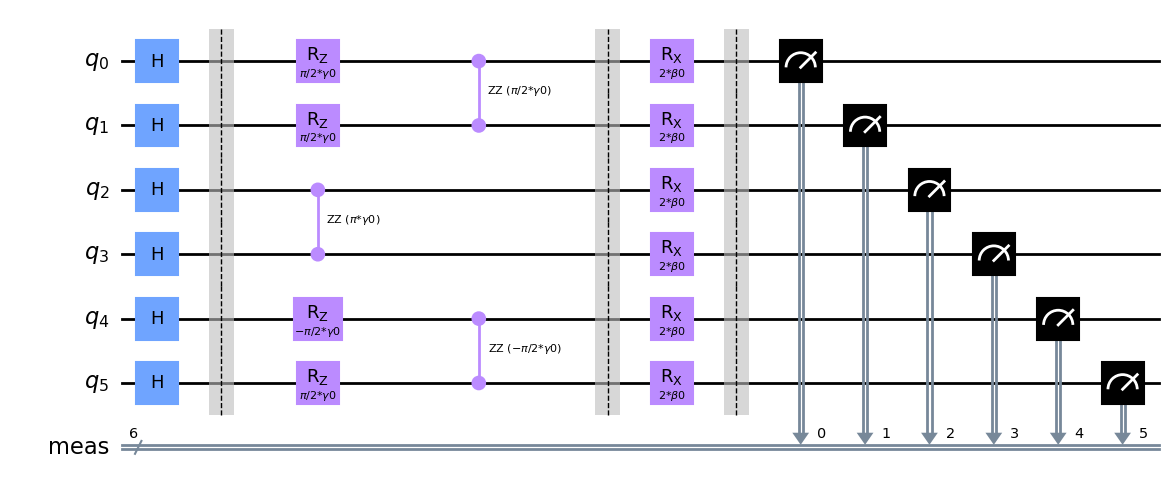

In [15]:
example_qaoa_circuit, _, _ = qaoa_circuit(qubo_problem_circuit, mixer.standard_mixer, sat_hamiltonian, 6, 1, amplitude_vector=None)
example_qaoa_circuit.draw(output="mpl")

### Quantum Routine

The circuit is executed and the circuit and the results are returned.

In [16]:
# QAOA Quantum Procedure
from qaoa.qaoa_application import quantum
%psource quantum

def quantum(problem_circuit: Callable, mixer_circuit: Callable, hamiltonian: DictArithmetic, nqubits: int, layers: int,
            beta_val_list: list[float], gamma_val_list: list[float], shots: int = 512,
            amplitude_vector: list[float] = None, params_per_layer: bool = True) -> tuple[Counts, QuantumCircuit]:
    qc, beta_list, gamma_list = qaoa_circuit(problem_circuit, mixer_circuit, hamiltonian, nqubits, layers,
                                             amplitude_vector=amplitude_vector, params_per_layer=params_per_layer)

    # Set parameters for qc
    for i in range(len(beta_val_list)):
        qc = qc.bind_parameters({
            beta_list[i]: beta_val_list[i],
            gamma_list[i]: gamma_val_list[i]
        })

    # run and measure qc
    qasm_sim = Aer.get_backend('qasm_simulator')
    transpiled_qaoa = transpile(qc, qasm_sim)
    results = qasm_sim.run(transpiled_qaoa, shots=shots).result()
    counts = results.get_counts()

    return counts, qc


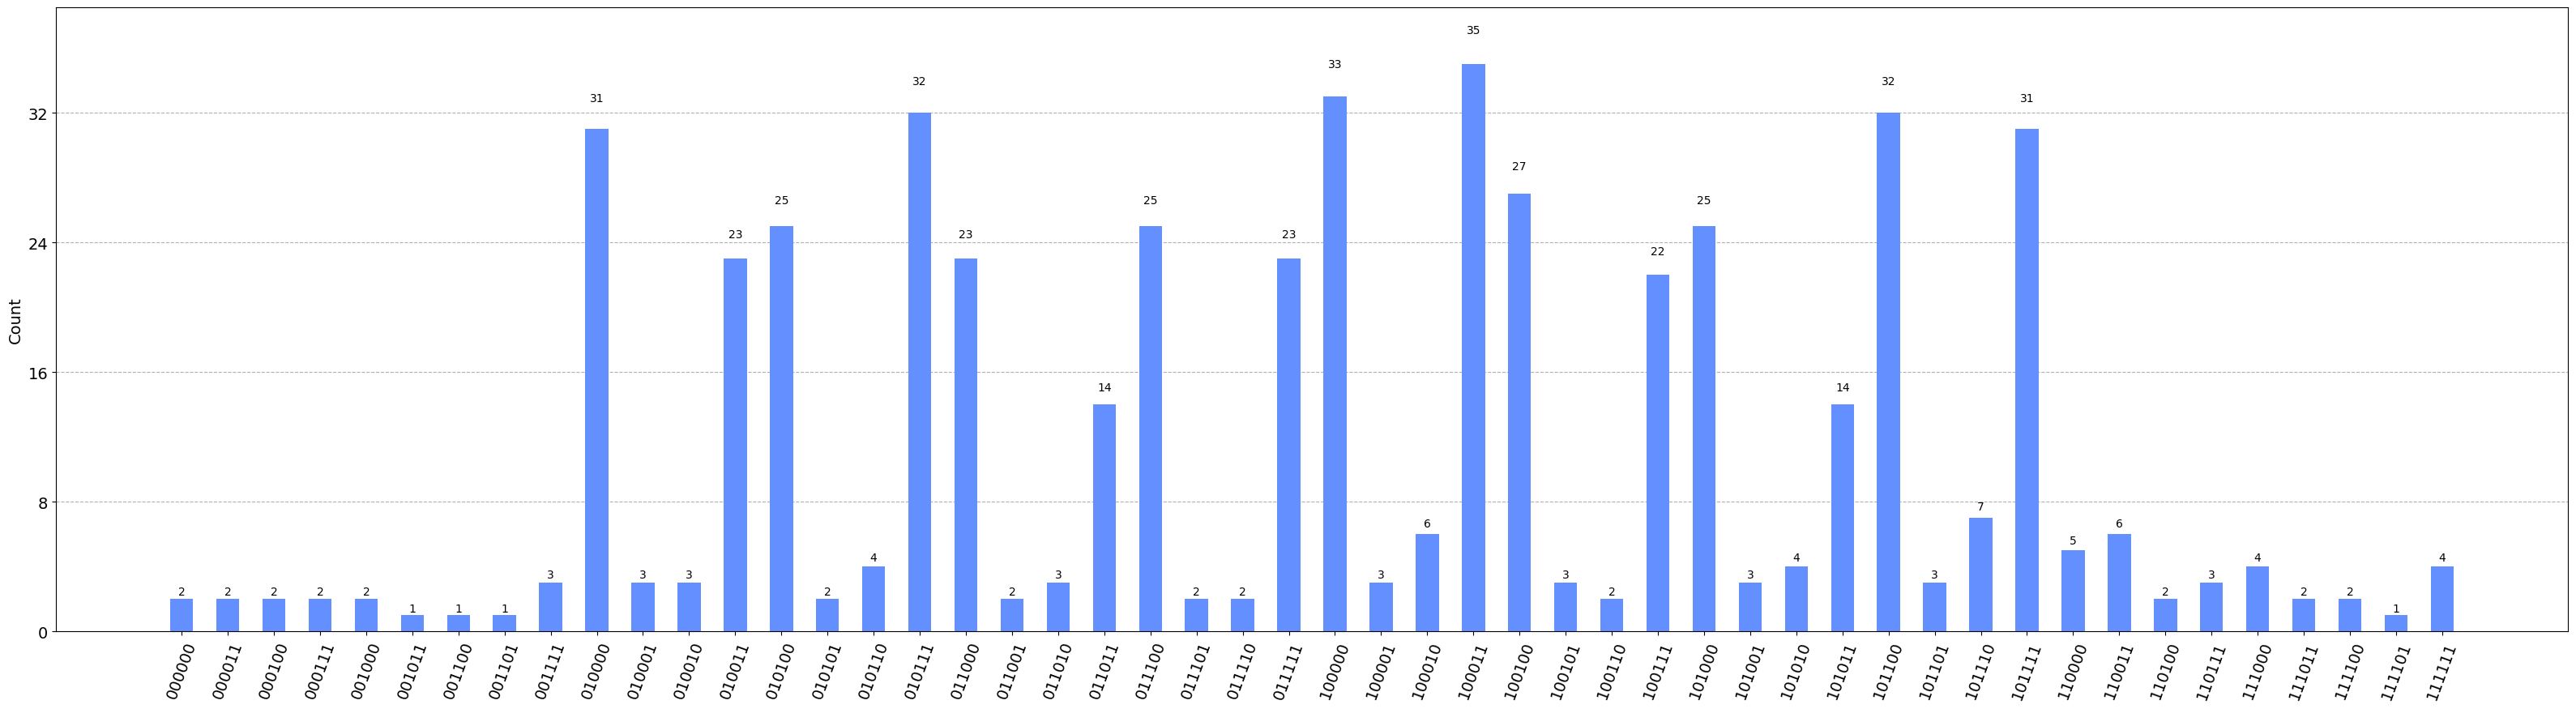

In [17]:
counts, qc = quantum(qubo_problem_circuit, mixer.standard_mixer, sat_hamiltonian, 6, 1, [1], [1])
plot_histogram(counts, figsize=(40, 10))

### Parameter Optimization

The parameters $\gamma$ and $\beta$ are optimized using a classical optimization algorithm.
The current implementation supports the `COBYLA`, `Powell`, `BFGS`, `Nelder-Mead` and `CG` algorithms from the `scipy` package.

In [18]:
from qaoa.qaoa_parameter_optimization import get_optimizer
%psource get_optimizer

def get_optimizer(method: str, maxiter: int = 1000, tol: float = 1e-12) -> Callable:
    """
        Returns the optimizer function for the given method.

        :param method: the optimization method used to optimize the parameters
        :param maxiter: the maximum number of iterations the optimizer is allowed to perform
        :param tol: the tolerance of the optimizer
    """
    if method == "COBYLA":
        optimizer = cobyla
    elif method == "Powell":
        optimizer = powell
    elif method == "BFGS":
        optimizer = bfgs
    elif method == "Nelder-Mead":
        optimizer = nelder_mead
    elif method == "CG":
        optimizer = cg
    else:
        raise ValueError("Invalid optimization method")

    def optimize(theta: list[dict], expectation: Callable, print_res: bool) -> list[dict]:
        """
            Optimizes the parameters beta and gamma of the QAOA circuit using the given method.

            :param theta: list of dictionaries with keys "beta" and "ga

# Creating a problem specific Hamiltonian

## Creating a cost function satisfying features

[Glover](https://arxiv.org/abs/1811.11538) described quadratic penalties for the 2-SAT problem by treating inputs as $0/1$ values, forming a traditional constraint and then deriving a quadratic penalty. We summarize their work here:

| Clause Type   | Example                        | Constraint                 | Penalty                     |
|---------------|--------------------------------|----------------------------|-----------------------------|
| No Negations  | $(x_i \vee x_j)$               | $x_i + x_j \geq 1$         | $(1 - x_i - x_j + x_i x_j)$ |
| One Negation  | $(x_i \vee \lnot{}x_j)$        | $x_i + (1-x_j) \geq 1$     | $(x_j - x_i x_j)$           |
| Two Negations | $(\lnot{}x_i \vee \lnot{}x_j)$ | $(1-x_i) + (1-x_j) \geq 1$ | $(x_i x_j)$                 |

Using these penalties we can transform our example into a QUBO model.

$$
y(\vec x) = 2-x_1-x_2-x_3-x_4+x_5+x_1*x_2+2*x_3*x_4-x_5*x_6
$$

$y(\vec x)$ is the integer of unsatisfied clauses. In other words, $y=0$ indicates that all clauses are satisfied, which is desired for this problem.

To get the penalties for general clauses $(x_i \vee \dots \vee x_j \vee \neg x_k \vee \dots \vee \neg x_l)$ which can contain more than two literals, we can use the following term to convert the clause into a Polynomial Unconstrained Binary Optimization (PUBO) model:

$$(1 - x_i) \dots (1 - x_j) (x_k) \dots (x_l)$$

If the clause consists of exactly two boolean variables, this is equivalent to the quadratic penalties described above.

## Creating a cost function for feature costs

For the feature costs, we can formulate a sum that adds a features cost if it is in the input vector $\vec x$.
$$
k(\vec x) = \sum_{x}^{} c_i x_i
$$


## Combining the functions
In our example, we want to find a valid configuration with the minimum cost, so we sum the two previous functions and add a penalty factor $\alpha$ to be able to change the influence of our SAT constraints.

$$
f(\vec x) = k(\vec x) + \alpha y(\vec x)
$$

We assume $\alpha \gg 0$, the exact value depends on the value of $k(\vec x)$.

## Forming Hamiltonians
We got our QUBO cost function defined. We now need to transform the Binary input space $x_i \in \{0,1\}$ to the Ising Spin model of $z_i \in \{-1, 1\}$. 

Replace $x_i$ with $z_i = 2x_i-1$ meaning $x_i = \frac{1 - z_i}{2}$ (Note that switching the sign changes the eigenvectors)

### Cost Hamiltonian for the SAT part
Before applying it to the entire function, let's first consider only $y(\vec x)$.

Ising Form:
$$
y(\vec z) = 2-\frac{1-z_1}{2}-\frac{1-z_2}{2}-\frac{1-z_3}{2}-\frac{1-z_4}{2}+\frac{1-z_5}{2}+\frac{1-z_1}{2}*\frac{1-z_2}{2}+2*\frac{1-z_3}{2}*\frac{1-z_4}{2}-\frac{1-z_5}{2}*\frac{1-z_6}{2}
$$
Simplified to (not really needed):
$$ 
y(\vec z) = (4 + z_2 + z_1 (1 + z_2) + 2 z_3 z_4 + z_6 - z_5 (1 + z_6))*\frac{1}{4}
$$
Which expands to:
$$
y(\vec z) = 1 + z_1\frac{1}{4} + z_2\frac{1}{4} + z_1 z_2\frac{1}{4} + z_3 z_4 \frac{1}{2} - z_5\frac{1}{4} + z_6\frac{1}{4} - z_5 z_6 \frac{1}{4}
$$
And leaves us with a cost hamiltonian $H_v$ with Pauli-Z-Gates $\sigma^z_i$ and an Identity $I$:
$$
H_v = 1*I + \sigma^z_1\frac{1}{4} + \sigma^z_2\frac{1}{4} + \sigma^z_1 \sigma^z_2\frac{1}{4} + \sigma^z_3 \sigma^z_4 \frac{1}{2} - \sigma^z_5\frac{1}{4} + \sigma^z_6\frac{1}{4} - \sigma^z_5 \sigma^z_6 \frac{1}{4}
$$

### Cost Hamiltonian for the feature costs
We can expand the feature costs in our example according to the table above.
$$
k(\vec x) = \sum_{x}^{} c_i x_i = 30*x_1 + 20*x_2 + 25*x_3 + 50*x_4 + 10*x_5 + 10*x_6
$$
Which we then again transform into Ising form.

$$
k(\vec z) = 15*(1-z_1) + 10*(1-z_2)+ 12.5*(1-z_3) + 25*(1-z_4) + 5*(1-z_5) + 5*(1-z_6) \\
k(\vec z) = 72.5 - 15 z_1 - 10 z_2 - 12.5 z_3 - 25 z_4 - 5 z_5 - 5 z_6
$$

Which leaves us with our cost Hamiltonian $H_{\mathit{fc}}$
$$
H_{\mathit{fc}} = 72.5*I - 15 \sigma^z_1 - 10 \sigma^z_2 - 12.5 \sigma^z_3 - 25 \sigma^z_4 - 5 \sigma^z_5 - 5 \sigma^z_6
$$

### Combining Hamiltonians

All that's left to do is choosing a suitable $\alpha$ and combining the functions.

We choose $\alpha = 200$ in this case.

$$
H_{C} = H_{\mathit{fc}} + \alpha ~ H_v
$$

$$
H_{C} = 72.5*I - 15 \sigma^z_1 - 10 \sigma^z_2 - 12.5 \sigma^z_3 - 25 \sigma^z_4 - 15 \sigma^z_5 - 5 \sigma^z_6  + 200*I + 50 \sigma^z_1 + 50 \sigma^z_2 + 50 \sigma^z_1 \sigma^z_2 + 100 \sigma^z_3 \sigma^z_4 - 50 \sigma^z_5 + 50 \sigma^z_6 - 50 \sigma^z_5 \sigma^z_6
$$

simplified to

$$
H_{C} = 272.5*I + 35 \sigma^z_1 + 40 \sigma^z_2 - 12.5 \sigma^z_3 -25 \sigma^z_4 - 55 \sigma^z_5 + 45 \sigma^z_6 + 50 \sigma^z_1 \sigma^z_2 + 100 \sigma^z_3 \sigma^z_4 - 50 \sigma^z_5 \sigma^z_6
$$

We can implement such a Hamiltonian $H_{C}$ using the `qubovert` library and solve small instances via bruteforce.

In [19]:
from util.hamiltonian_math import solve_bruteforce
%psource solve_bruteforce

def solve_bruteforce(model):
    model_solution = model.solve_bruteforce()
    print("Variable assignment:", model_solution)
    print("Model value:", model.value(model_solution))
    print("Constraints satisfied?", model.is_solution_valid(model_solution))  # we don't have constraints in our model


In [20]:
from qubovert import spin_var
# define spin variables 
z1, z2, z3, z4, z5, z6 = spin_var('z1'), spin_var('z2'), spin_var('z3'), spin_var('z4'), spin_var('z5'), spin_var('z6')

# Our manually calculated hamiltonian
featcost_model = 272.5 + 35 * z1 + 40 * z2 - 12.5 * z3 - 25 * z4 - 55 * z5 + 45 * z6 + 50 * z1 * z2 + 100 * z3 * z4 - 50 * z5 * z6
solve_bruteforce(featcost_model)

Variable assignment: {'z1': 1, 'z2': -1, 'z3': -1, 'z4': 1, 'z5': 1, 'z6': 1}
Model value: 45.0
Constraints satisfied? True


We can also define the SAT ($H_v$) and cost ($H_{\mathit{fc}}$) Hamiltonians separately and combine them afterwards.

In [21]:
# cost and sat individually
from qubovert import boolean_var

# define binary vars
x1, x2, x3, x4, x5, x6 = boolean_var('x1'), boolean_var('x2'), boolean_var('x3'), boolean_var('x4'), boolean_var('x5'), boolean_var('x6')

# SAT Penalty
alpha_sat = 200 # 1e6

# SAT QUBO
sat_model = alpha_sat * (2 - x1 - x2 - x3 - x4 + x5 + x1 * x2 + 2 * x3 * x4 - x5 * x6)

# Cost QUBO
cost_model = 30*x1 + 20*x2 + 25*x3 + 50*x4 + 10*x5 + 10*x6

# Combine models
combined_model = sat_model +  cost_model
print("QUBO Combined Model:")
pprint(combined_model)
print("Ising Combined Model: ")
combined_hamiltonian = combined_model.to_quso()
print(combined_hamiltonian)

solve_bruteforce(combined_model)

QUBO Combined Model:
{(): 400,
 ('x1',): -170,
 ('x1', 'x2'): 200,
 ('x2',): -180,
 ('x3',): -175,
 ('x3', 'x4'): 400,
 ('x4',): -150,
 ('x5',): 210,
 ('x5', 'x6'): -200,
 ('x6',): 10}
Ising Combined Model: 
{(0,): 35.0, (): 272.5, (1,): 40.0, (2,): -12.5, (3,): -25.0, (4,): -55.0, (0, 1): 50.0, (2, 3): 100.0, (4, 5): -50.0, (5,): 45.0}
Variable assignment: {'x1': 0, 'x2': 1, 'x3': 1, 'x4': 0, 'x5': 0, 'x6': 0}
Model value: 45
Constraints satisfied? True


## Classical Routine
On the classical side we now need functions to evaluate $C$, which correspond to computing the energy of the Hamiltonian for a specific measured output (a configuration in our case) by `compute_config_energy`.

In [22]:
from util.hamiltonian_math import compute_config_energy
%psource compute_config_energy

def compute_config_energy(hamiltonian: DictArithmetic, config: list[int]) -> float:
    """
        Computes the energy of a given configuration (ising input) for a given hamiltonian (ising form)

        :param hamiltonian: The hamiltonian to compute the energy for
        :param config: The configuration to compute the energy for
    """
    energy = 0
    for key, factor in hamiltonian.items():
        term_energy = factor
        for qubit in key:
            term_energy *= config[-qubit - 1]
        energy += term_energy
    return energy


As the circuit is executed multiple times the function `compute_hamiltonian_energy` can be used with different strategies.
Currently, we provide average, top and minimum strategies and the best one to use is `'avg'`.

In [23]:
from util.hamiltonian_math import compute_hamiltonian_energy, hamiltonian_strategy_average, hamiltonian_strategy_top, hamiltonian_strategy_min
%psource compute_hamiltonian_energy
%psource hamiltonian_strategy_average
%psource hamiltonian_strategy_top
%psource hamiltonian_strategy_min

def compute_hamiltonian_energy(hamiltonian, counts, strategy='avg'):
    """
        Compute the energy state of a hamiltonian from measurements.
        
        :param hamiltonian: the hamiltonian (QUSO/PUSO) describing the system
        :param counts: measurement results for a quantum system for the hamiltonian
        :param strategy: method for actually evaluating the hamiltonian. Available: 'avg', 'top', 'min'
    """
    if strategy == 'avg':
        return hamiltonian_strategy_average(hamiltonian, counts)
    elif strategy == 'top':
        return hamiltonian_strategy_top(hamiltonian, counts)
    elif strategy == 'min':
        return hamiltonian_strategy_min(hamiltonian, counts)
    else:
        raise RuntimeError(f"Unsupported strategy: {strategy}")

def hamiltonian_strategy_average(hamiltonian, counts):
    """
        Computes the average energy across the entire measurement for the given hamiltonian
    """
    average_energy = 0
    for config_str in counts.keys():
    

We can then define a function that given a beta and gamma as input creates a quantum circuit, executes it multiple times and returns the energy.

This function can be used in a classical optimizer.

In [24]:
from qaoa.qaoa_application import get_expectation
%psource get_expectation

def get_expectation(problem_circuit: Callable, mixer_circuit: Callable, hamiltonian: DictArithmetic, nqubits: int,
                    nlayers: int, shots: int = 128, amplitude_vector: list[float] = None, params_per_layer: bool = True,
                    strategy: str = 'avg') -> Callable:
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta: list[float]):
        qc, beta_list, gamma_list = qaoa_circuit(problem_circuit, mixer_circuit, hamiltonian, nqubits, nlayers,
                                                 amplitude_vector=amplitude_vector, params_per_layer=params_per_layer)
        # Set parameters for qc
        for i in range(math.floor(len(theta) / 2)):
            qc = qc.bind_parameters({
                beta_list[i]: theta[2 * i],
                gamma_list[i]: theta[(2 * i) + 1]
            })
        counts = backend.run(qc, nshots=shots).result().get_counts()
        return compute_hamiltonian_energy(hamiltonian, count

We can visualize the cost landscape using $f$-$\mu$ and $\beta$-$\gamma$ plots.

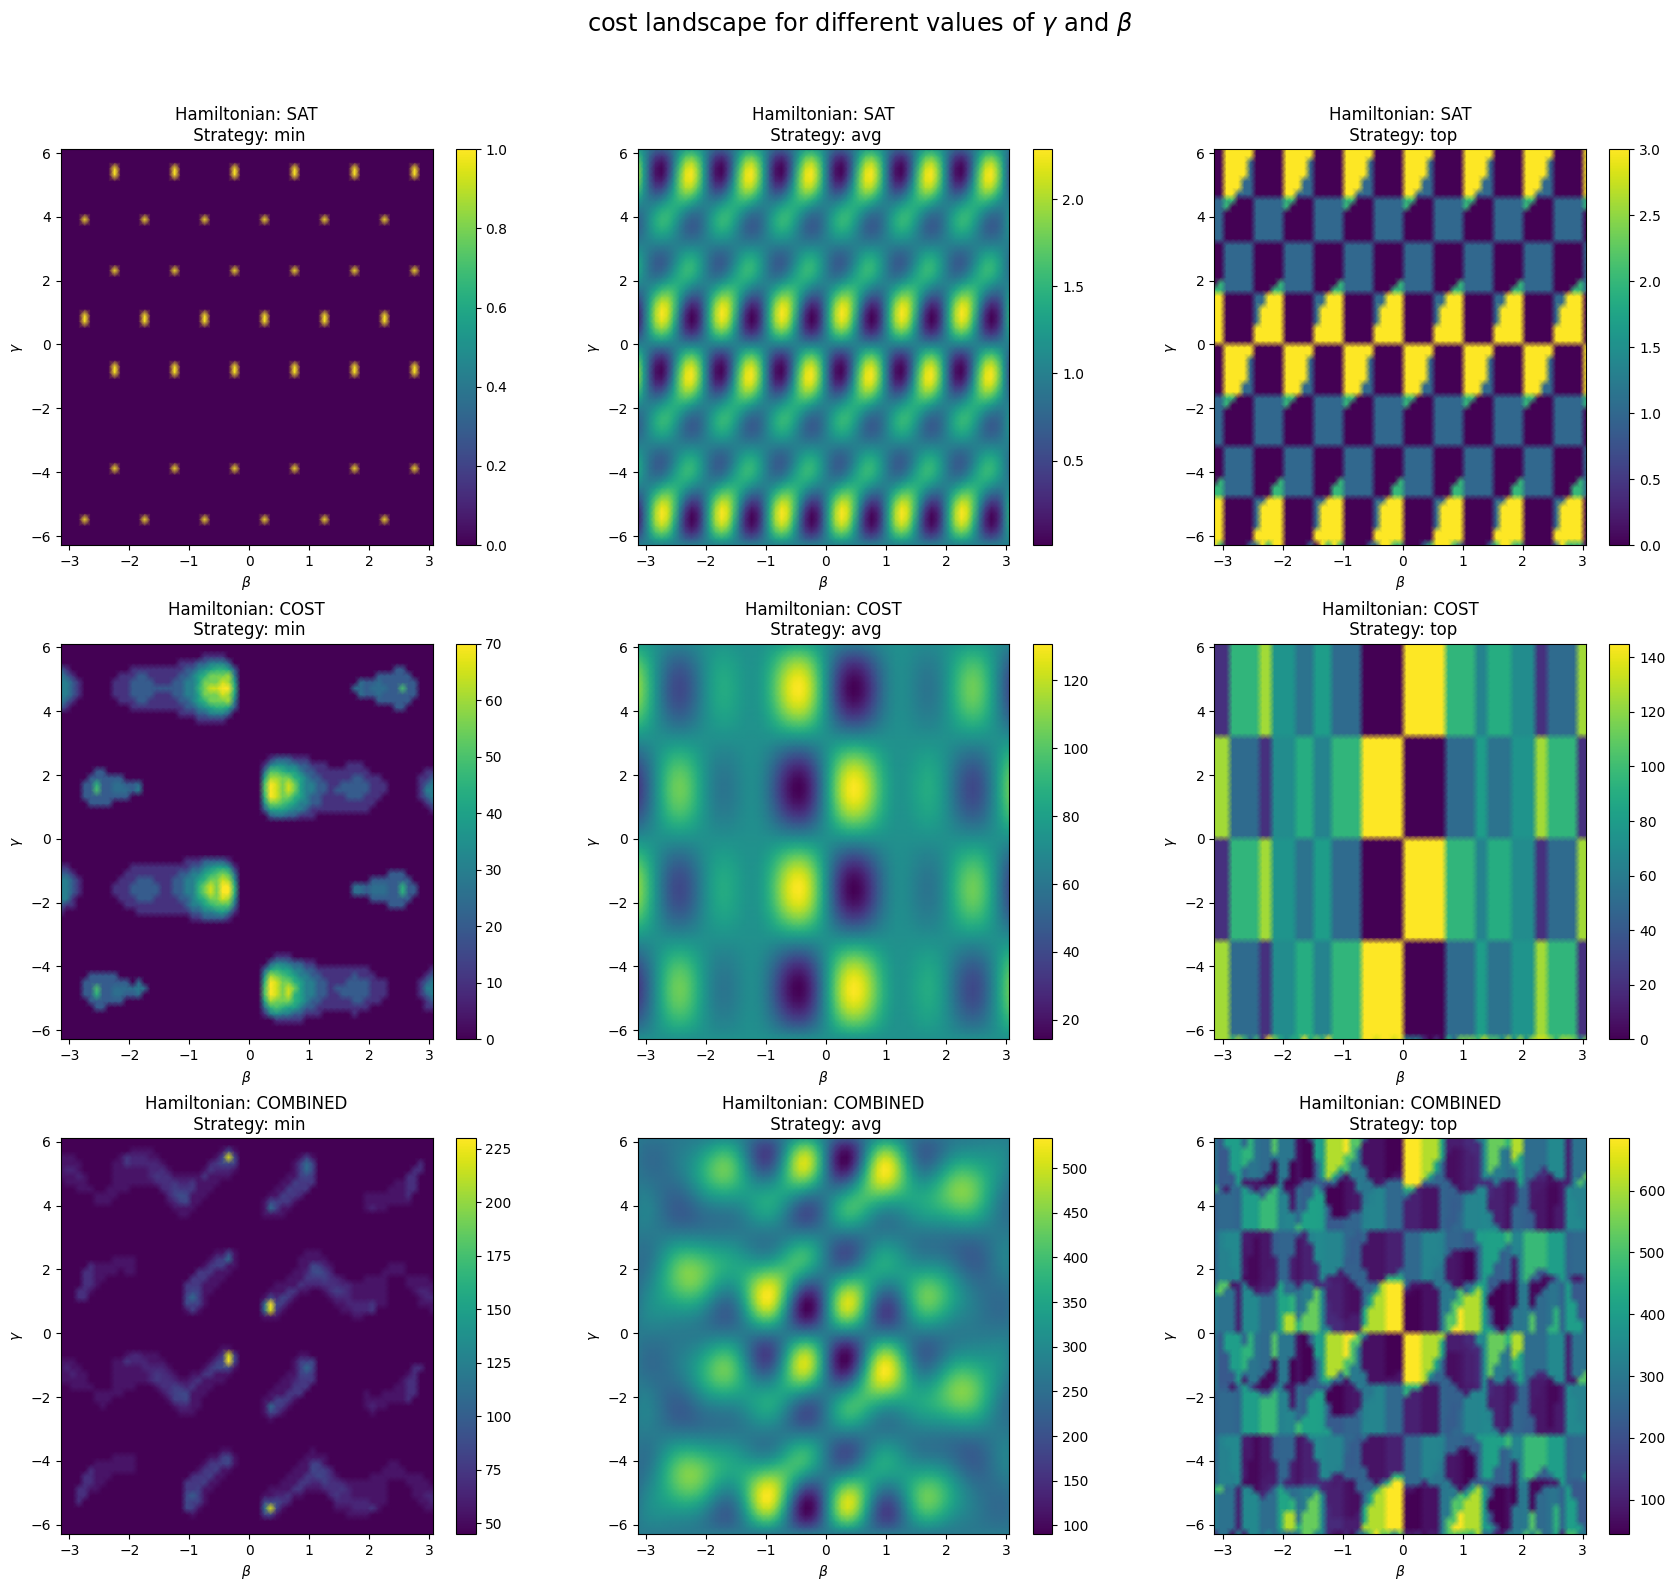

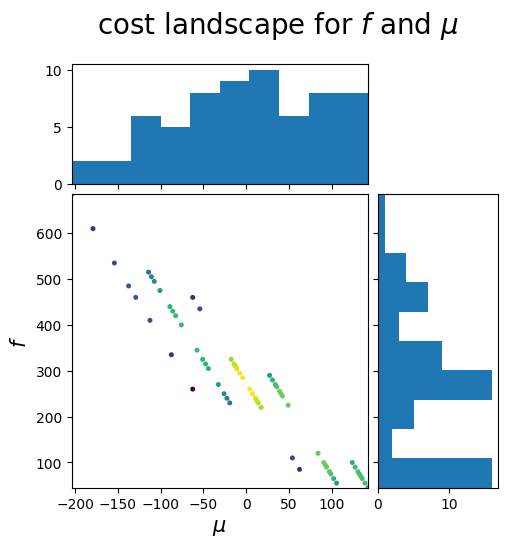

In [25]:
from util.visualization import plot_beta_gamma_cost_landscape, plot_f_mu_cost_landscape
# Plot cost landscape for different values of beta and gamma
hamiltonians = [{'hamiltonian': sat_hamiltonian, 'name': 'SAT'},
                {'hamiltonian': cost_model.to_quso(), 'name': 'COST'},
                {'hamiltonian': combined_hamiltonian, 'name': 'COMBINED'}]
strategies = ['min', 'avg', 'top']
plot_beta_gamma_cost_landscape(qubo_problem_circuit, mixer.standard_mixer, hamiltonians, strategies, 6, 0.1)

# Plot cost landscape for different f and mu
plot_f_mu_cost_landscape(combined_hamiltonian, 6)

# Applying QAOA

Finally, we can run the whole algorithm for a specific problem Hamiltonian.

In [26]:
from qaoa.qaoa_application import apply_qaoa_statevector
%psource apply_qaoa_statevector

def apply_qaoa_statevector(problem_circuit: Callable, mixer_circuit: Callable, parameter_optimization: Callable,
                           hamiltonian: DictArithmetic, layers: int = 60, n_features: int = 6,
                           theta={"beta": 0.01, "gamma": -0.01}, warmstart_statevector: list[float] = None,
                           strategy: str = 'avg', use_optimizer: bool = True, params_per_layer: bool = True,
                           print_res: bool = True) -> tuple[list[float], QuantumCircuit]:
    """
        Applies the QAOA Algorithm for the given hamiltonian in QUSO/PUSO form.

        :param problem_circuit: The function for creating the corresponding problem quantum circuit
        :param mixer_circuit: The function for creating the corresponding mixer quantum circuit
        :param parameter_optimization: The method for optimizing the parameters
        :param hamiltonian: the hamiltonian used for creating the quantum circuit
                            and determ

In [27]:
import qaoa.qaoa_parameter_optimization as parameter_optimization
from util.hamiltonian_math import get_hamiltonian_dimension
import numpy as np

# QAOA Example Application Using Optimizer
hamiltonian = combined_hamiltonian # min-cost SAT
# hamiltonian = sat_model.to_quso()   # just SAT

# warmstart array for specific SAT instance of this notebook
warmstart_statevector = \
      [0.        , 0.        , 0.        , 0.        , 0.        ,
       0.232379  , 0.28809721, 0.20976177, 0.        , 0.25298221,
       0.19493589, 0.24899799, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.20976177, 0.17888544, 0.23021729,
       0.        , 0.24899799, 0.23664319, 0.29664794, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.23021729, 0.24083189,
       0.26267851, 0.        , 0.232379  , 0.20248457, 0.20736441,
       0.04472136, 0.        , 0.        , 0.        ]

mixer_circuit = mixer.warmstart_mixer
parameter_optimization = parameter_optimization.get_optimizer('COBYLA')
layers = 5 # more layers = higher approximation rate but more quantum errors when running on real qpu
theta = {"beta": 0.01, "gamma": -0.01} # start values for optimization
strategy = 'avg'
use_warmstart = True
use_optimizer = True

if not use_warmstart:
    warmstart_statevector = None

probabilities, _ = apply_qaoa_statevector(qubo_problem_circuit, mixer_circuit, parameter_optimization, hamiltonian, layers, get_hamiltonian_dimension(hamiltonian), theta, warmstart_statevector, strategy=strategy, use_optimizer=use_optimizer, print_res=False)
probabilities_dict = {}
for i in range(0, 2 ** get_hamiltonian_dimension(hamiltonian)):
    probabilities_dict[(np.binary_repr(i, width=6))] = round(probabilities[i], 4)

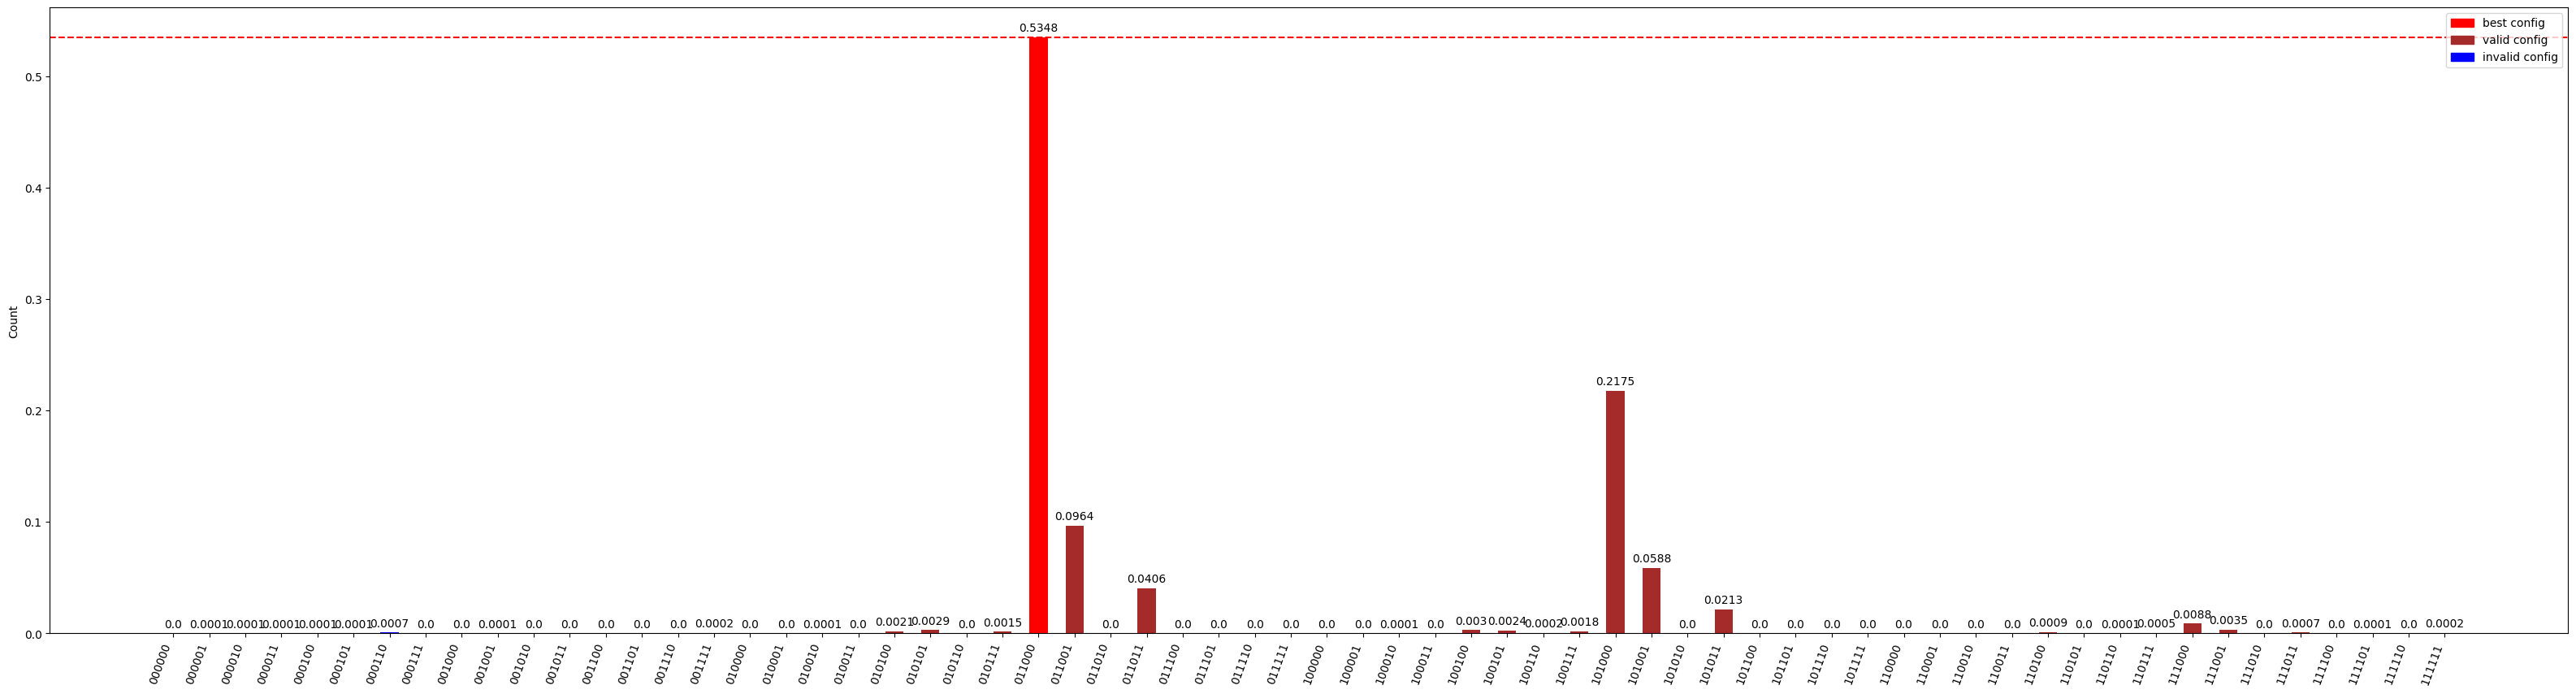

In [28]:
# Pretty Print the results of the previous Cell
from util.visualization import plot_counts_histogram

best_config = "000110" # 654321
valid_configs = ["101010", "101001", "101011", "100110", "100101", "100111", "001010", "001001", "001011", "000101", "000111", "111010", "111001", "111011", "110110", "110101", "110111"]

plot_counts_histogram(probabilities_dict, get_hamiltonian_dimension(hamiltonian), best_config, valid_configs)

## PUBO vs QUBO Hamiltonian

For general problem Hamiltonians which might contain $k$-local terms with $k > 2$ we can either directly implement them using the `pubo_problem_circuit` function or convert them into a QUBO Hamiltonian using the `qubovert` library and implement the resulting quadratized Hamiltonian using the `qubo_problem_circuit` function.

The quadratized QUBO Hamiltonian has lower circuit depth, but uses more qubits than the PUBO Hamiltonian.

The following describes how a PUBO Hamiltonian can be transformed into a QUBO Hamiltonian using a simple quadratization method.
For example, if we transform the clause $(x_i \vee x_j \vee x_k)$, we get the following penalty:

$$1 - x_i - x_j - x_k + x_i x_j + x_i x_k + x_j x_k - x_i x_j x_k$$

By introducing a new auxiliary variable $w_{ij} = x_i x_j$ we can rewrite this penalty as:

$$1 - x_i - x_j - x_k + w_{ij} + x_i x_k + x_j x_k - w_{ij} x_k$$

To enforce the constraint $w_{ij} = x_i x_j$ we add (a multiple of) the penalty term $x_i x_j - 2 x_i w_{ij} - 2 x_j w_{ij} + 3 w_{ij}$ to the Hamiltonian resulting in the overall penalty:

$$1 - x_i x_j - x_k + w_{ij} + x_i x_k + x_j x_k - w_{ij} x_k + x_i x_j - 2 x_i w_{ij} - 2 x_j w_{ij} + 3 w_{ij}$$

This term no longer contains a product of three variables but products of at most two variables and can therefore be used in a QUBO model.
The method for reduction by substitution above was first described by I. G. Rosenberg in "Reduction of Bivalent Maximization to the Quadratic Case" (1975) and can be found in a collection of different quadratization methods by [Dattani](https://arxiv.org/pdf/1901.04405.pdf).

We use the `to_quso()` function from the `qubovert` library to quadratize the PUBO model.
After applying QAOA to the resulting QUBO model, we can use the `convert_ancilla_bit_results()` function to convert the results back to the original PUBO model.

In [29]:
from util.model_transformation import convert_to_penalty

sat_instance = [[(x1, True), (x2, True)],
              [(x2, True), (x3, False), (x4, True)],
              [(x3, True), (x5, False), (x6, False)]]

# SAT PUBO
sat_model = convert_to_penalty(sat_instance)

# Combine models
combined_model = cost_model + alpha_sat * sat_model
combined_hamiltonian = combined_model.to_puso()
pprint(combined_hamiltonian)

{(): 172.5,
 (0,): 35.0,
 (0, 1): 50.0,
 (1,): 65.0,
 (1, 2): -25.0,
 (1, 2, 3): -25.0,
 (1, 3): 25.0,
 (2,): -12.5,
 (2, 3): -25.0,
 (2, 4): -25.0,
 (2, 4, 5): 25.0,
 (2, 5): -25.0,
 (4,): -30.0,
 (4, 5): 25.0,
 (5,): -30.0}


In [30]:
# Applying QAOA to the PUBO Hamiltonian

mixer_circuit = mixer.standard_mixer
hamiltonian = combined_hamiltonian
n_features = 6
warmstart_statevector = None

probabilities, _ = apply_qaoa_statevector(pubo_problem_circuit, mixer_circuit, parameter_optimization, hamiltonian, layers, get_hamiltonian_dimension(hamiltonian), theta, warmstart_statevector, strategy=strategy, use_optimizer=use_optimizer, print_res=False)
probabilities_dict = {}
for i in range(0, 2 ** get_hamiltonian_dimension(hamiltonian)):
    probabilities_dict[(np.binary_repr(i, width=6))] = round(probabilities[i], 4)

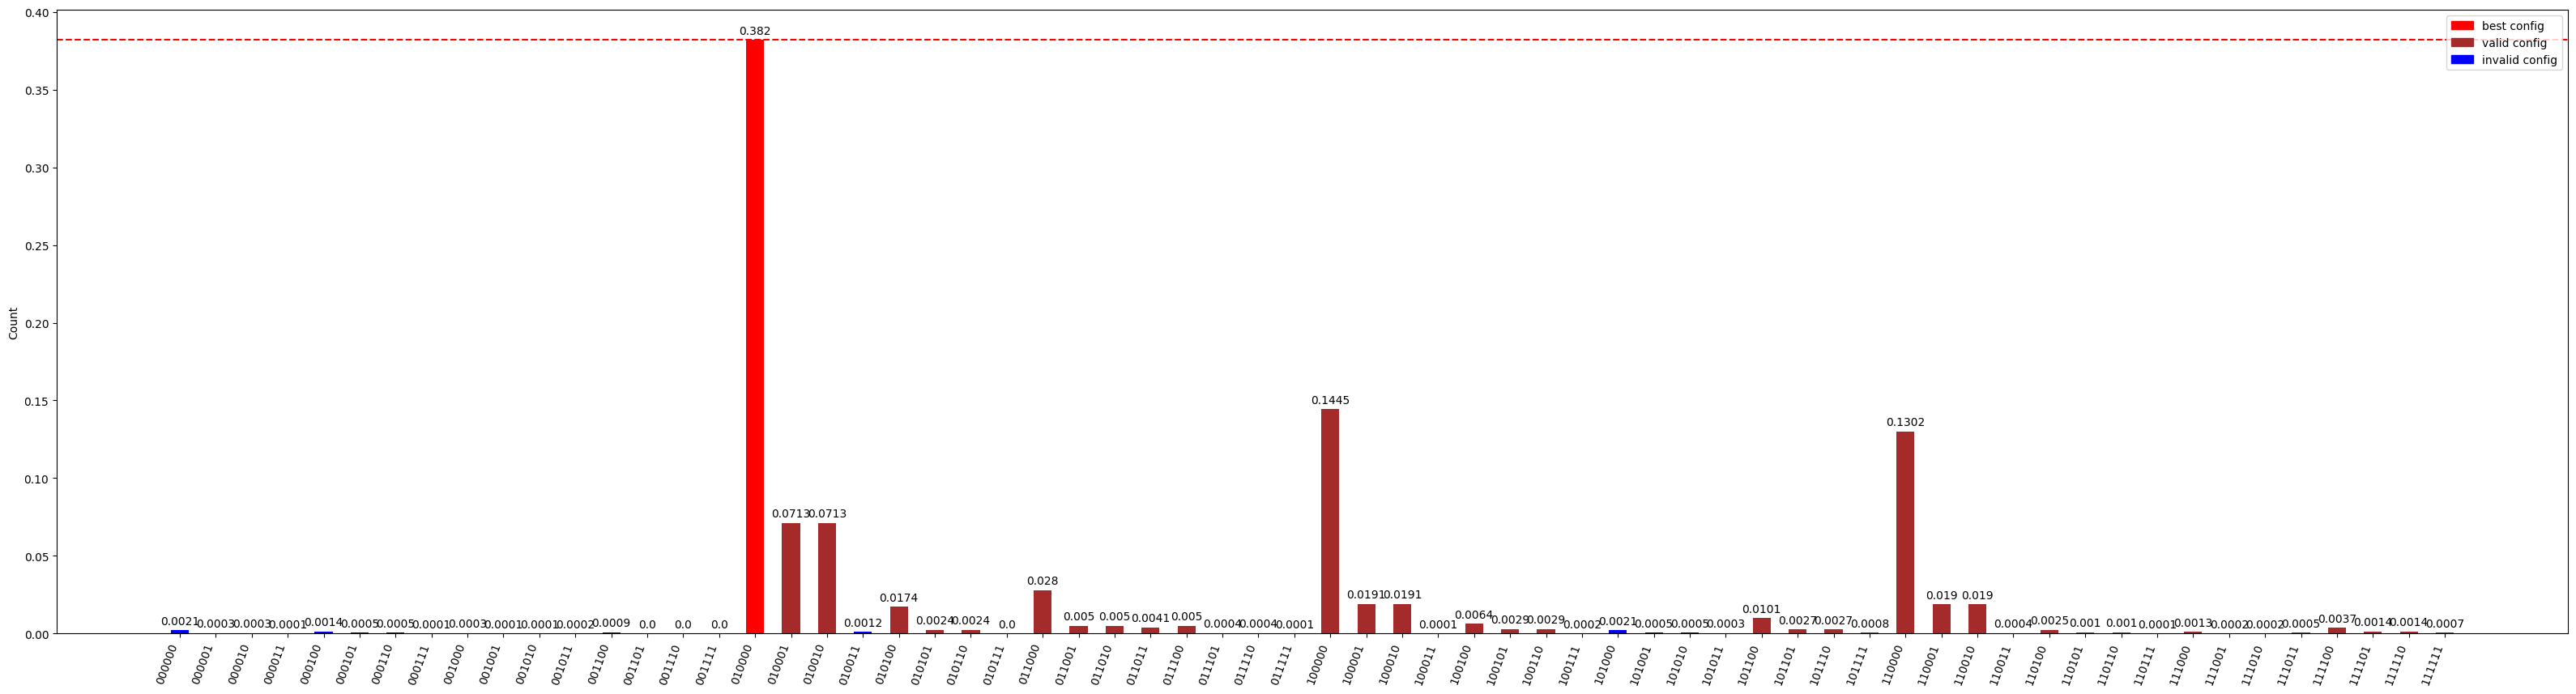

In [31]:
best_config = "000010" # 654321
valid_configs = ["111111", "011111", "101111", "001111", "110111", "010111", "100111", "000111", "011011", "101011", "001011", "010011", "100011", "000011", "111101", "011101", "101101", "001101", "011001", "101001", "001001", "010001", "100001", "000001", "111110", "011110", "101110", "001110", "110110", "010110", "100110", "000110", "011010", "101010", "001010", "010010", "100010", "000010"]

plot_counts_histogram(probabilities_dict, get_hamiltonian_dimension(hamiltonian), best_config, valid_configs)

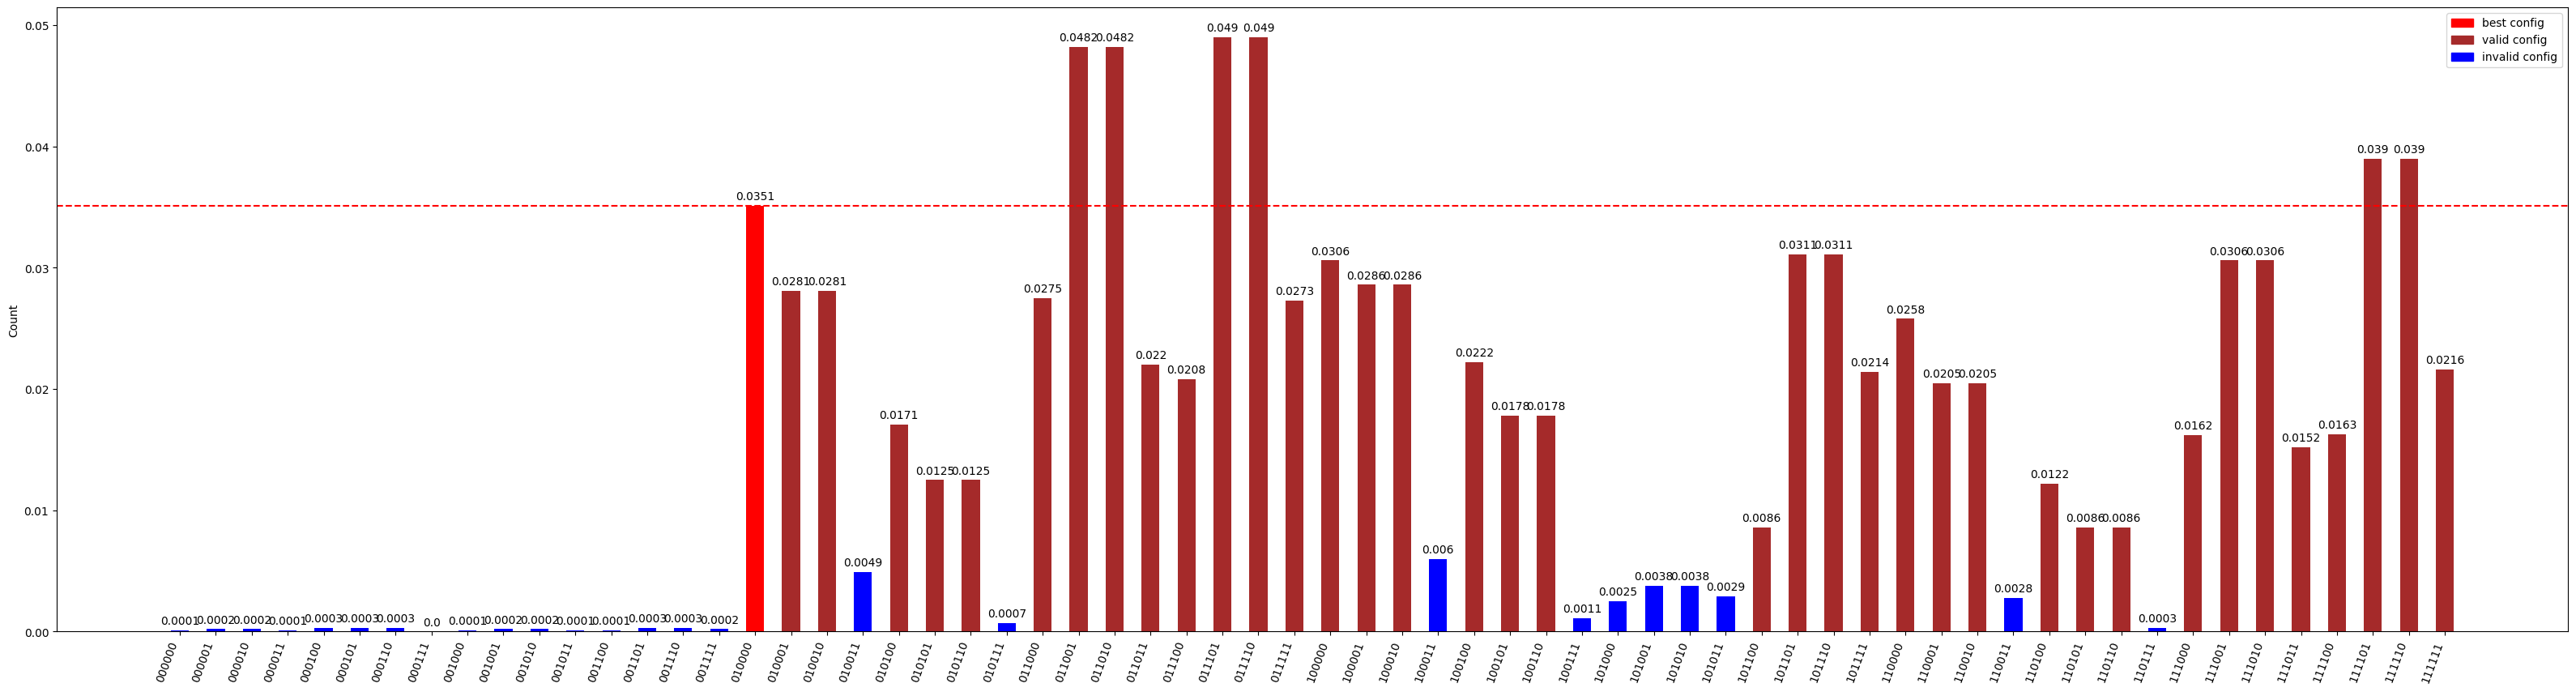

In [32]:
# Applying QAOA to the quadratized QUBO Hamiltonian

from qaoa.qaoa_mincost_k_sat import convert_ancilla_bit_results

qubo_hamiltonian = combined_model.to_quso()

probabilities, _ = apply_qaoa_statevector(qubo_problem_circuit, mixer_circuit, parameter_optimization, qubo_hamiltonian, layers, get_hamiltonian_dimension(qubo_hamiltonian), theta, warmstart_statevector, strategy=strategy, use_optimizer=use_optimizer, print_res=False)
probabilities_dict = {}
for i in range(0, 2 ** get_hamiltonian_dimension(qubo_hamiltonian)):
    probabilities_dict[np.binary_repr(i, width=get_hamiltonian_dimension(qubo_hamiltonian))] = probabilities[i]

probabilities_dict = convert_ancilla_bit_results(probabilities_dict, n_features)

for key in probabilities_dict:
    probabilities_dict[key] = round(probabilities_dict[key], 4)

plot_counts_histogram(probabilities_dict, n_features, best_config, valid_configs)

# Scalability of our approach

Our approach requires qubits equal to the number of features using the PUBO and additional qubits using the QUBO formulation. Circuit depth scales better for the QUBO than for the PUBO formulation.

We can measure the circuit depth of individual circuits using the `.depth()` method the `QuantumCircuit` class from Qiskit.
The depth can be measured for the whole circuit or for individual parts of the circuit like for example the phase-separating operator or the mixing operator.
We can measure the circuit width of individual circuits that are required for a specific Hamiltonian using the `get_hamiltonian_dimension()` method.

In general, we can observe that for the QUBO variant, the width increases and the depth decreases with a higher number of literals per clause.
Depth also increases with a higher number of literals per clause.
As the PUBO variant does not require any auxiliary variables, the circuit width is equal to the number of features.
The depth depends on the number of clauses and the number of literals per clause.
The exact circuit sizes vary with the structure of the specific instance.

In [33]:
print("PUBO Hamiltonian circuit width: ", get_hamiltonian_dimension(hamiltonian))
print("PUBO Hamiltonian circuit depth (depth of phase-separating operator per layer): ", pubo_problem_circuit(sat_hamiltonian, get_hamiltonian_dimension(hamiltonian), Parameter("$\\gamma$")).depth())

print("QUBO Hamiltonian circuit width: ", get_hamiltonian_dimension(qubo_hamiltonian))
print("QUBO Hamiltonian circuit depth (depth of phase-separating operator per layer): ", qubo_problem_circuit(sat_hamiltonian, get_hamiltonian_dimension(qubo_hamiltonian), Parameter("$\\gamma$")).depth())

PUBO Hamiltonian circuit width:  6
PUBO Hamiltonian circuit depth (depth of phase-separating operator per layer):  4
QUBO Hamiltonian circuit width:  8
QUBO Hamiltonian circuit depth (depth of phase-separating operator per layer):  2
